<a href="https://colab.research.google.com/github/dionp3/Proyek-Klasifikasi-Gambar/blob/main/Proyek_Klasifikasi_Gambar_Submission_Akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Dion Prayoga
- **Email:** donpr2003@gmail.com | mc116d5y2010@student.devacademy.id
- **ID Dicoding:** dionp3

## Import Semua Packages/Library yang Digunakan

📦 Instalasi TensorFlow.js di Google Colab

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


📚 Import Library untuk Training Model Klasifikasi Gambar di Google Colab

In [3]:
# Import library standar
import os
import io
import zipfile

# Import library third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

# Import TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import modul untuk Google Colab
from google.colab import files
from google.colab import drive

## Data Preparation

### Data Loading

🔗 Mount Google Drive ke Google Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


📂 Akses File dari Google Drive di Google Colab

In [6]:
'/content/My Drive/Colab Notebooks/cat-dog-images-for-classification.zip'

'/content/My Drive/Colab Notebooks/cat-dog-images-for-classification.zip'

📦 Cell 1: Ekstrak file zip

In [8]:
zip_file_path = "/content/drive/My Drive/Colab Notebooks/cat-dog-images-for-classification.zip"
extraction_path = "data"

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"File {zip_file_path} berhasil diekstrak ke folder {extraction_path}.")
except Exception as e:
    print(f"Terjadi kesalahan saat mengekstrak file: {e}")

File /content/drive/My Drive/Colab Notebooks/cat-dog-images-for-classification.zip berhasil diekstrak ke folder data.


📄 Cell 2: Load file CSV ke DataFrame

In [9]:
csv_file_path = os.path.join(extraction_path, "cat_dog.csv")
df = pd.read_csv(csv_file_path)

🛠️ Cell 3: Modifikasi kolom 'image' dan 'labels'

In [10]:
df['image'] = df['image'].apply(lambda x: os.path.join(extraction_path, "cat_dog", x))
df['labels'] = df['labels'].astype(str)

🔍 Cell 4: Filter file yang ada dan tampilkan info dataset

In [11]:
df = df[df['image'].apply(os.path.exists)]

image_count = len(df)
label_counts = df['labels'].value_counts().to_dict()
print(f"Dataset: {image_count} images ({label_counts})")

Dataset: 25000 images ({'1': 12500, '0': 12500})


### Data Preprocessing

#### Split Dataset

📊 Cell 1: Membagi Dataset

In [12]:
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Training set: 15000 images
Validation set: 5000 images
Test set: 5000 images


🔄 Cell 2: Membuat Generator

In [13]:
def create_generator(df, augment=False):
    return ImageDataGenerator(
        rescale=1./255,
        **({'rotation_range': 20, 'horizontal_flip': True} if augment else {})
    ).flow_from_dataframe(
        dataframe=df,
        x_col='image',
        y_col='labels',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=augment
    )

🏋️‍♂️ Cell 3: Membuat Train, Validation, dan Test Generator

In [14]:
train_gen = create_generator(train_df, augment=True)
val_gen = create_generator(val_df)
test_gen = create_generator(test_df)

Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Modelling

🏗️ Cell 1: Membuat Arsitektur Model CNN

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

⚙️ Cell 2: Kompilasi Model

In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


🏃‍♂️ Cell 3: Melatih Model

In [17]:
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 852s 2s/step - accuracy: 0.5864 - loss: 0.6766 - val_accuracy: 0.7362 - val_loss: 0.5521
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 846s 2s/step - accuracy: 0.7136 - loss: 0.5587 - val_accuracy: 0.7778 - val_loss: 0.4716
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 858s 2s/step - accuracy: 0.7663 - loss: 0.4963 - val_accuracy: 0.8092 - val_loss: 0.4253
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.7892 - loss: 0.4429 - val_accuracy: 0.8236 - val_loss: 0.3934
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.8121 - loss: 0.4079 - val_accuracy: 0.8308 - val_loss: 0.3976
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 854s 2s/step - accuracy: 0.8368 - loss: 0.3768 - val_accuracy: 0.8410 - val_loss: 0.3477
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 829s 2s/step - accuracy: 0.8437 - loss: 0.3601 - val_accuracy: 0.8536 - val_loss: 0.3350
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 843s 2s/step - accuracy: 0.8455 - loss: 0.3460 - val_accu

## Evaluasi dan Visualisasi

🖼️ Cell 1: Set Ukuran Figure

In [19]:
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

📊 Cell 2: Plot Akurasi

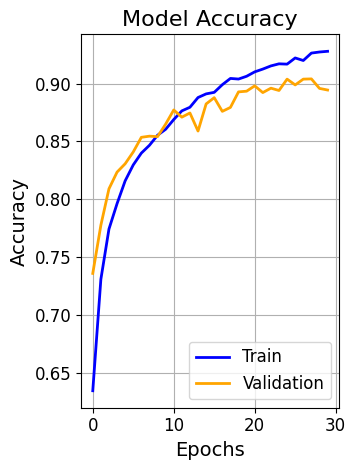

In [20]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linewidth=2)
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

📉 Cell 3: Plot Loss

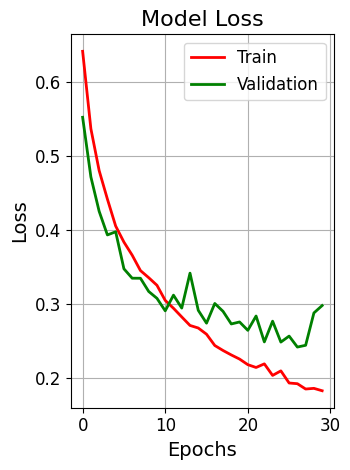

In [21]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', color='green', linewidth=2)
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

🧪 Evaluasi Kinerja Model pada Data Latih dan Data Uji

In [23]:
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"✅ Akurasi pada Data Latih: {train_acc:.2%}")
print(f"✅ Loss pada Data Latih: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"🎯 Akurasi pada Data Uji: {test_acc:.2%}")
print(f"🎯 Loss pada Data Uji: {test_loss:.4f}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 304s 646ms/step - accuracy: 0.9342 - loss: 0.1627
✅ Akurasi pada Data Latih: 93.69%
✅ Loss pada Data Latih: 0.1602
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 484ms/step - accuracy: 0.8916 - loss: 0.3076
🎯 Akurasi pada Data Uji: 89.10%
🎯 Loss pada Data Uji: 0.3054


Output tersebut menunjukkan hasil evaluasi model setelah proses pelatihan selesai. Pada data latih, model mencapai akurasi sebesar 93,69% dengan loss (kesalahan prediksi) sebesar 0,1602, yang menandakan model mampu mempelajari pola dari data latih dengan sangat baik. Sedangkan pada data uji, akurasi sedikit lebih rendah yaitu 89,10% dengan loss sebesar 0,3054, yang masih termasuk tinggi dan menunjukkan bahwa model cukup generalize terhadap data baru yang belum pernah dilihat sebelumnya. Perbedaan akurasi ini wajar dan menunjukkan model tidak mengalami overfitting yang parah. Secara keseluruhan, model bekerja dengan sangat baik pada tugas klasifikasi kucing dan anjing ini. 🚀

## Konversi Model

Menyimpan model sebagai savedmodel

In [24]:
tf.saved_model.save(model, 'saved_model')

Menyimpan model sebagai tflite

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

with open('tflite/label.txt', 'w') as f:
    f.write("Cat\nDog\n")

Saved artifact at '/tmp/tmp83lpwmwa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138391436422864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391429587856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391429594768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391429579408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391429594384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391373531280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391443215312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391373532048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391373532432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138391373533968: TensorSpec(shape=(), dtype=tf.resource, name=None)


Menyimpan model sebagai tfjs

In [26]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-27 14:28:24.623939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745764104.688556  118010 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745764104.708294  118010 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-27 14:28:35.961469: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745764116.232661  118010 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

Saving download.jpg to download (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


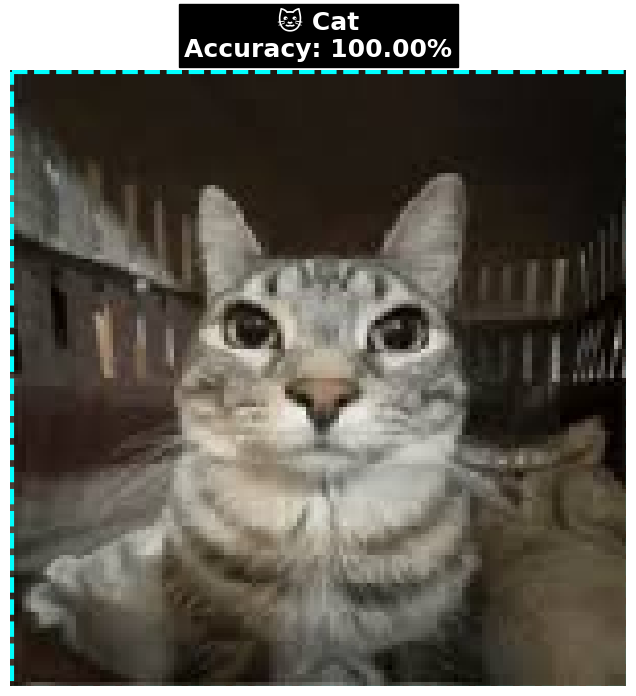

Prediction for 'download (3).jpg': 🐱 Cat with 100.00% accuracy


In [31]:
uploaded_files = files.upload()

for file_name in uploaded_files.keys():
    img_data = uploaded_files[file_name]
    img = image.load_img(io.BytesIO(img_data), target_size=(150, 150))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "🐶 Dog" if prediction > 0.5 else "🐱 Cat"
    accuracy = max(prediction, 1 - prediction) * 100

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)
    ax.axis('off')

    plt.title(
        f"{label}\nAccuracy: {accuracy:.2f}%",
        fontsize=18, fontweight='bold', color='white',
        backgroundcolor='black', pad=10
    )

    plt.gca().add_patch(plt.Rectangle(
        (0, 0), 150, 150, linewidth=3, edgecolor='cyan', facecolor='none', linestyle='--'
    ))

    plt.show()

    print(f"Prediction for '{file_name}': {label} with {accuracy:.2f}% accuracy")


In [32]:
!pip freeze > requirements.txt